In [3]:
import sys
import torch

sys.path.append('..')

from lift.teacher import load_teacher
from lift.environments.gym_envs import NpGymEnv
from lift.controllers import MITrainer

from configs import BaseConfig

/Users/kilian/opt/miniconda3/envs/lift/lib/python3.11/site-packages/tensordict/_pytree.py:147: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  register_pytree_node(


In [4]:
# load BC
config = BaseConfig()
teacher = load_teacher(config)

env = NpGymEnv(
    "FetchReachDense-v2", 
    cat_obs=True, 
    cat_keys=config.teacher.env_cat_keys,
)

# load bc encoder
bc_trainer = torch.load(config.models_path / "bc.pt")

# init trainer
trainer = MITrainer(config, env, teacher)
trainer.encoder.load_state_dict(bc_trainer.encoder.state_dict())

/Users/kilian/opt/miniconda3/envs/lift/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.num_envs to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.num_envs` for environment variables or `env.get_wrapper_attr('num_envs')` that will search the reminding wrappers.
  logger.warn(
/Users/kilian/opt/miniconda3/envs/lift/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.reward_space to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.reward_space` for environment variables or `env.get_wrapper_attr('reward_space')` that will search the reminding wrappers.
  logger.warn(
/Users/kilian/opt/miniconda3/envs/lift/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.num_envs to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you 

<All keys matched successfully>

In [5]:
from lift.datasets import load_all_mad_datasets, mad_labels_to_actions, mad_groupby_labels, mad_augmentation, compute_features
mad_windows, mad_labels = load_all_mad_datasets(
    config.mad_base_path.as_posix(),
    num_channels=config.n_channels,
    emg_range=config.emg_range,
    window_size=config.window_size,
    window_overlap=config.window_overlap,
    desired_labels=config.desired_mad_labels,
    skip_person='Female0',
    return_tensors=True,
)
mad_features = compute_features(mad_windows)
mad_actions = mad_labels_to_actions(
    mad_labels, recording_strength=config.simulator.recording_strength,
)

window_list, label_list = mad_groupby_labels(mad_windows, mad_labels)
actions_list = mad_labels_to_actions(
    label_list, recording_strength=config.simulator.recording_strength,
)
sample_windows, sample_actions = mad_augmentation(
    window_list, 
    actions_list, 
    config.pretrain.num_augmentation,
    augmentation_distribution=config.pretrain.augmentation_distribution
)
sample_features = compute_features(sample_windows)

skipping Female0
skipping Female0
skipping Female0
skipping Female0
MAD dataset loaded


In [7]:
trainer.encoder.eval()
with torch.no_grad():
    mad_preds = trainer.encoder.sample(mad_features)

In [12]:
mad_preds_binary = torch.zeros_like(mad_preds)
mad_preds_binary[mad_preds > 0.5] = 1
mad_preds_binary[mad_preds < -0.5] = -1

In [15]:
(mad_preds_binary == mad_actions).type(torch.float).mean()

tensor(0.7962)

In [23]:
from lift.datasets import MAD_LABELS_TO_DOF
MAD_LABELS_TO_DOF = torch.tensor(MAD_LABELS_TO_DOF)

In [49]:
pred_labels = []
mad_short_labels = []
for i, pred_act in enumerate(mad_preds_binary):
    label = torch.where((MAD_LABELS_TO_DOF == pred_act).all(dim=1))[0]
    if not len(label) == 0:
        pred_labels.append(label.item())
        mad_short_labels.append(mad_labels[i])
pred_labels = torch.tensor(pred_labels)
mad_short_labels = torch.tensor(mad_short_labels)

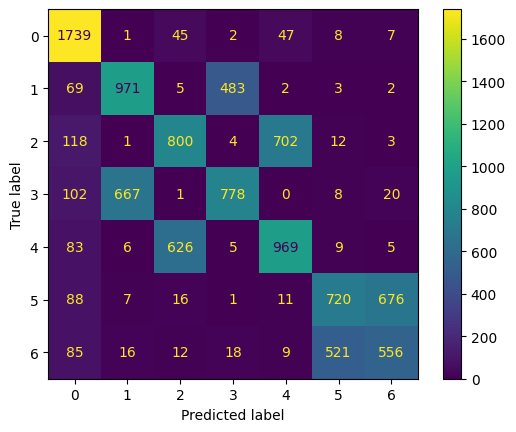

In [56]:
# confusion matrix between pred_labels and mad_labels
from sklearn import metrics
import matplotlib.pyplot as plt
confusion_matrix = metrics.confusion_matrix(mad_short_labels, pred_labels)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = mad_short_labels.unique().tolist())

cm_display.plot()
plt.show()

In [57]:
with torch.no_grad():
    sample_preds = trainer.encoder.sample(sample_features)

In [77]:
ae = (sample_preds - sample_actions).abs()
ae_mad = (mad_preds - mad_actions).abs()

In [89]:
ae.mean(), ae_mad.mean()

(tensor(0.5556), tensor(0.3418))

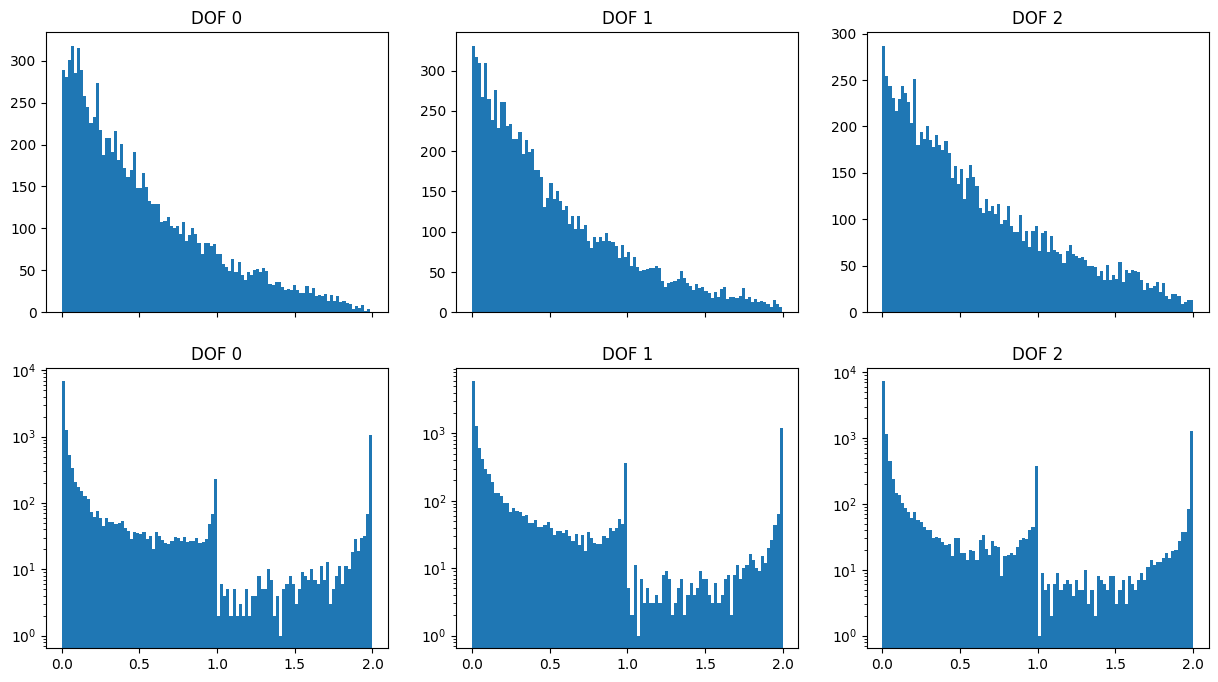

In [88]:
fig, axs = plt.subplots(2, 3, figsize=(15, 8), sharex=True)
for i in range(3):
    axs[0,i].hist(ae[:,i].numpy(), bins=100)
    axs[0,i].set_title(f"DOF {i}")

for i in range(3):
    axs[1,i].hist(ae_mad[:,i].numpy(), bins=100)
    axs[1,i].set_title(f"DOF {i}")
    axs[1,i].set_yscale('log')

plt.show()